## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

ключевые вопросы HR-агентства:

    Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

In [338]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from statsmodels.stats.descriptivestats import sign_test

import matplotlib.pyplot as plt
import seaborn as sns


# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [339]:
# загружаем датасет
data = pd.read_csv('ds_salaries.csv', index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [340]:
#Удаляем неиформатиные стобцы
data = data.drop(columns=['salary', 'salary_currency'], inplace=False)
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


work_year 	Год, в котором была выплачена зарплата.

experience_level 	Опыт работы на этой должности в течение года со следующими возможными значениями:

        EN — Entry-level/Junior;
        MI — Mid-level/Intermediate;
        SE — Senior-level/Expert;
        EX — Executive-level/Director.

employment_type 	Тип трудоустройства для этой роли:

        PT — неполный рабочий день;
        FT — полный рабочий день;
        CT — контракт;
        FL — фриланс.

job_title 	Роль, в которой соискатель работал в течение года.

salary_in_usd 	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).

employee_residence 	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.

remote_ratio 	Общий объём работы, выполняемой удалённо. Возможные значения:

        0 — удалённой работы нет (менее 20 %);
        50 — частично удалённая работа;
        100 — полностью удалённая работа (более 80 %).

company_location 	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.

company_size 	Среднее количество людей, работавших в компании в течение года:

        S — менее 50 сотрудников (небольшая компания);
        M — от 50 до 250 сотрудников (средняя компания);
        L — более 250 сотрудников (крупная компания).


In [341]:
# перевод категориального признака в количественный
data['experience_level'] = data['experience_level'].replace(["EN", "MI", "SE", "EX"], [1, 2, 3, 4])
data['employment_type'] = data['employment_type'].replace(["PT", "FT", "CT", "FL"], [1, 2, 3, 4])
data['remote_ratio'] = data['remote_ratio'].replace([0, 50, 100], [1, 2, 3])
data['company_size'] = data['company_size'].replace(["S", "M", "L"], [1, 2, 3])

C:\Users\Stromont\AppData\Local\Temp\ipykernel_17952\3128425604.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Stromont\AppData\Local\Temp\ipykernel_17952\3128425604.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Stromont\AppData\Local\Temp\ipykernel_17952\3128425604.py:5: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_opt

In [342]:
corel = data.corr(numeric_only = True)
corel

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size
work_year,1.000000,0.294759,-0.012819,0.170493,0.076314,-0.078764
experience_level,0.294759,1.000000,0.081701,0.484233,0.097784,0.063511
employment_type,-0.012819,0.081701,1.000000,0.065747,0.015638,0.027133
salary_in_usd,0.170493,0.484233,0.065747,1.000000,0.132122,0.151205
remote_ratio,0.076314,0.097784,0.015638,0.132122,1.000000,-0.022070
company_size,-0.078764,0.063511,0.027133,0.151205,-0.022070,1.000000


Чтобы проверить корреляционную связь между страной соискателя и страной фирмы можно использовать тест хи-квадрат

In [343]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


### Зависимость переменных employee_residence и company_location


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): переменная employee_residence($μ_1$) статистически не зависима от перменной company_location($μ_2$).

*Альтернативная гипотеза* ($H_1$): переменная employee_residence($μ_1$) статистически зависима от перменной company_location($μ_2$).

In [344]:
table = pd.crosstab(data['employee_residence'], data['company_location'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Так как переменные employee_residence и company_location зависимы друг от друга, то можно одну из переменных убрать как статистически не значимую

In [345]:
data = data.drop(columns=['employee_residence'])

# Описательный анализ

In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   work_year         607 non-null    int64 
 1   experience_level  607 non-null    int64 
 2   employment_type   607 non-null    int64 
 3   job_title         607 non-null    object
 4   salary_in_usd     607 non-null    int64 
 5   remote_ratio      607 non-null    int64 
 6   company_location  607 non-null    object
 7   company_size      607 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 42.7+ KB


В датасете 607 записей без пропусков, типы данных соответствуют данным

In [347]:
# Проверяем на дубликаты
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 8)


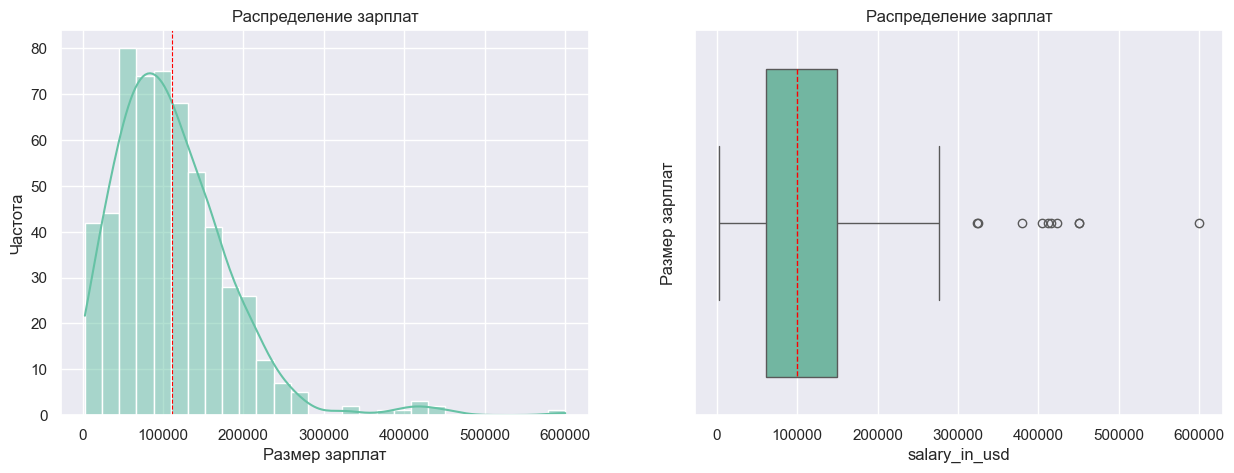

In [348]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплат', ylabel='Частота')
axes[0].set_title('Распределение зарплат')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплат')
axes[1].set_title('Распределение зарплат')

plt.show()

In [349]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат']
data_agg

,Размер зарплат
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Распределение зарплат, как и ожидалось, отличается от нормального, а так же имеются выбросы

## Изучение зависимости зарплаты Data Scientist от разных признаков

2025-04-10 21:02:59,394 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-04-10 21:02:59,410 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


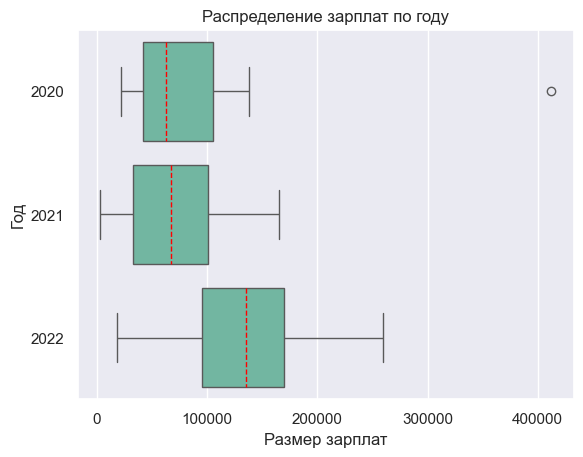

In [350]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Год')
plt.title('Распределение зарплат по году')
plt.show()

In [351]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('work_year')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от года')
data_agg

Зарплаты в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


На первый взгляд распределения зарплат для разных годов различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

2025-04-10 21:02:59,720 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-10 21:02:59,730 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


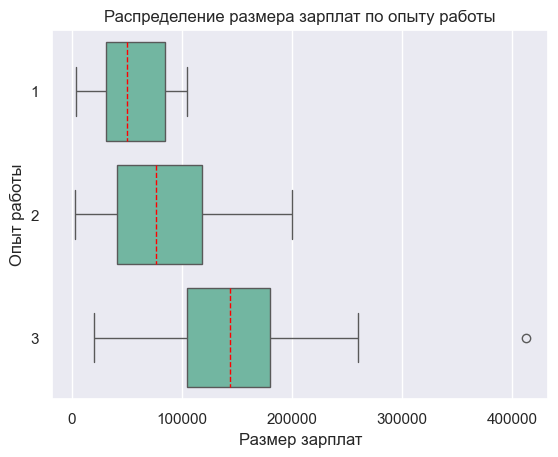

In [352]:

ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Опыт работы')
plt.title('Распределение размера зарплат по опыту работы')
plt.show()

In [353]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Размер зарплаты по опыту работы')
data_agg

Размер зарплаты по опыту работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
1,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
2,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
3,49.0,150710.86,62918.63,20171.0,104890.0,144000.0,180000.00,412000.0


На первый взгляд распределения зарплат для разного опыта работы различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

2025-04-10 21:03:00,015 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-10 21:03:00,029 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


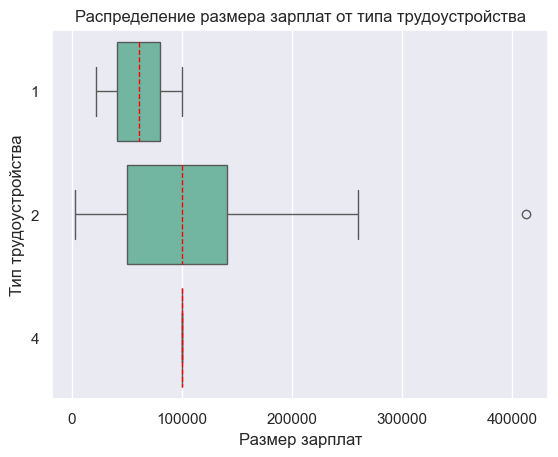

In [354]:

ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Тип трудоустройства')
plt.title('Распределение размера зарплат от типа трудоустройства')
plt.show()


In [355]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Размер зарплаты от типа трудоустройства')
data_agg

Размер зарплаты от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
1,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0
2,127.0,104031.94,64309.23,2859.0,50660.50,100000.0,140850.00,412000.0
4,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0


Не имеет смысла искать зависимость вида трудоустройства от зарплаты, так как слишком мало специалистов Data Scientist, работающих не по полному рабочему дню

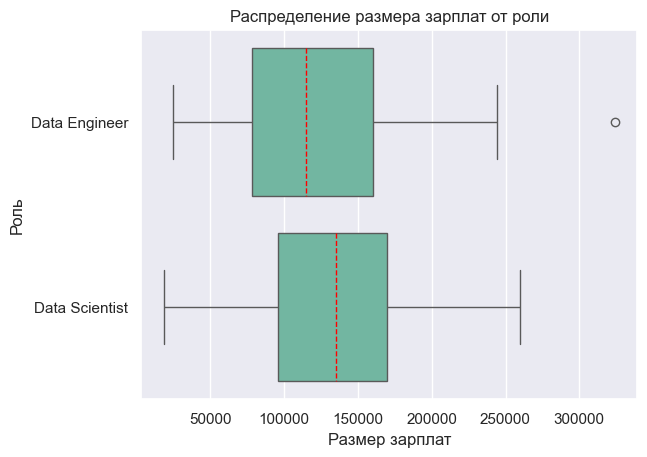

In [356]:
df = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]
df = df[df['work_year'] == 2022]
ax = sns.boxplot(df, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Роль')
plt.title('Распределение размера зарплат от роли')
plt.show()


In [357]:
data_agg = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])].groupby('job_title')['salary_in_usd'].describe().round(2)
print('Размер зарплаты от типа трудоустройства')
data_agg

Размер зарплаты от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,121.0,109750.03,58203.68,4000.0,66022.00,100800.0,150000.0,324000.0
Data Scientist,130.0,103336.35,63967.56,2859.0,50330.25,100000.0,140400.0,412000.0


На первый взгляд распределения зарплат для разной роли соискателя различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

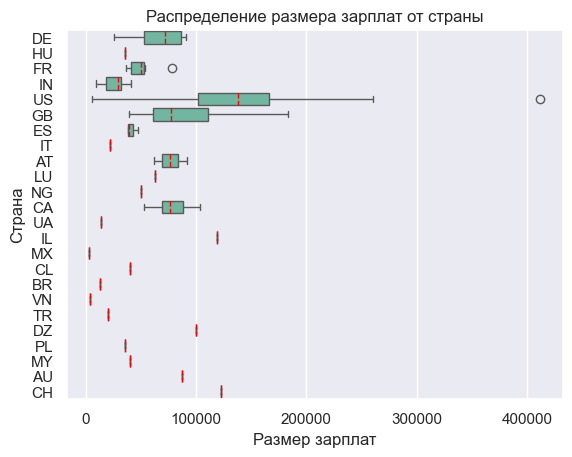

In [358]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Страна')
plt.title('Распределение размера зарплат от страны')
plt.show()

In [359]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('company_location')['salary_in_usd'].describe().round(2)
print('Размер зарплаты от  страны')
data_agg

Размер зарплаты от  страны


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AT,2.0,76352.00,21050.57,61467.0,68909.5,76352.0,83794.50,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.0,86703.0,86703.00,86703.0
BR,1.0,12901.00,NaN,12901.0,12901.0,12901.0,12901.00,12901.0
CA,5.0,77787.00,19301.65,52396.0,69336.0,75774.0,87738.00,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.0,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.0,40038.0,40038.00,40038.0
DE,6.0,66124.50,25473.80,25532.0,52632.5,71279.5,86448.75,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.0,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.5,38776.0,42792.50,46809.0


Нет смысла искать статистическую значимость влияния стран на зарплату, потому что в большинстве стран приведено по одному примеру, что не достаточно для проверки

2025-04-10 21:03:01,280 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-10 21:03:01,291 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


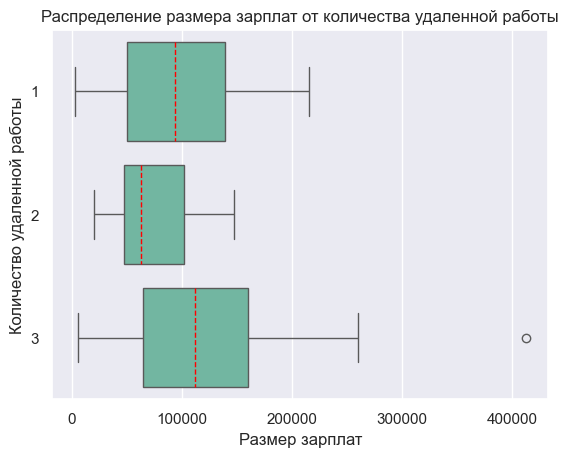

In [360]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Количество удаленной работы')
plt.title('Распределение размера зарплат от количества удаленной работы')
plt.show()

In [361]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Размер зарплаты от количества удаленной работы')
data_agg

Размер зарплаты от количества удаленной работы


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
1,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
2,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
3,68.0,116484.54,70908.36,5679.0,64420.00,111500.0,160000.0,412000.0


На первый взгляд распределения зарплат для разной степени количества удаленной работы соискателя различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

2025-04-10 21:03:01,583 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-10 21:03:01,588 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


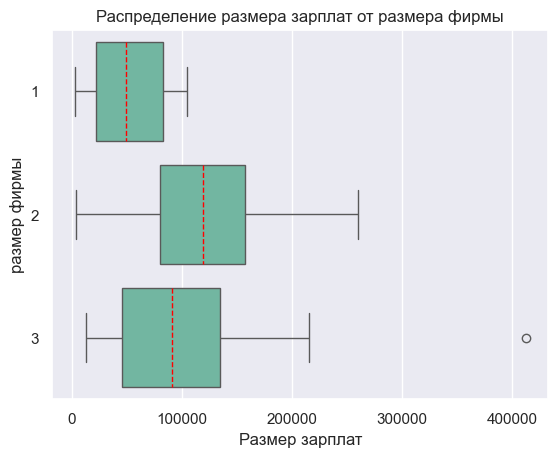

In [362]:
ax = sns.boxplot(data[data['job_title']=='Data Scientist'], x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='размер фирмы')
plt.title('Распределение размера зарплат от размера фирмы')
plt.show()

In [363]:
data_agg = data[data['job_title']=='Data Scientist'].groupby('company_size')['salary_in_usd'].describe().round(2)
print('Размер зарплаты от размера фирмы')
data_agg

Размер зарплаты от размера фирмы


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
1,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0
2,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
3,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0


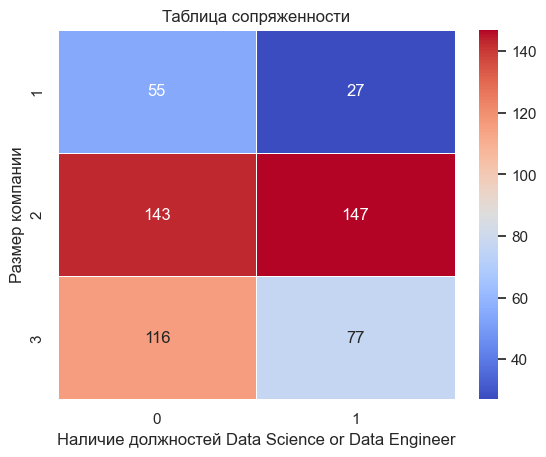

In [364]:
df = data.copy()
df['data sci or eng'] = df['job_title'].apply(lambda x : 1 if x=='Data Scientist' or x=='Data Engineer' else 0)

cross_tab = pd.crosstab(index=df['company_size'], columns=df['data sci or eng'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Наличие должностей Data Science or Data Engineer', ylabel='Размер компании')
plt.title('Таблица сопряженности')
plt.show()

Согласно данным, зависимость наличия должностей от размера компании есть. Чтобы определить, являются ли это статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

## Промежуточный вывод

Согласно графикам, можно сделать вывод, что все оcтавшиеся критерии влияют на зарплату специалиста Data Scientist

## Статистический анализ данных

In [365]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат в 2020 ($μ_1$) статистически больше либо равен размеру зарплат в 2021 ($μ_2$).

$$ H_0 : μ_1 => μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат в 2020 ($μ_1$) статистически меньше размеру зарплат в 2021 ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

Здесь же проверим данное утверждение для следующих двух лет

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат в 2021 ($μ_1$) статистически больше либо равен размеру зарплат в 2022 ($μ_2$).

$$ H_0 : μ_1 => μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат в 2021 ($μ_1$) статистически меньше размеру зарплат в 2022 ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [366]:
df = data[data['job_title']=='Data Scientist']
# значения страховых выплат
salary_2020 = df.loc[df['work_year']==2020, 'salary_in_usd']
salary_2021 = df.loc[df['work_year']==2021, 'salary_in_usd']
salary_2022 = df.loc[df['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест для 2020 и 2021 годов**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [367]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2020, salary_2021, alternative='less')
decision_hypothesis(p)

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Выберем подходящий статистический тест для 2020 и 2021 годов**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий

**Проведём тест**

In [368]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(salary_2021, salary_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест
_, p = stats.ttest_ind(salary_2021, salary_2022, alternative='less', equal_var=True)

decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.264
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод

Исходя из результатов статистических тестов нельзя сказать, что между 2020 и 2021 годом наблюдался рост зарлпта специалистов Data Scintist, при этом между 2021 и 2022 годом согласно результатам теста рост зарплат был.

### Равны ли зарплаты специалиста Data Scientist с разным опытом работы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат Entry-level ($μ_1$) статистически равен размеру зарплат Mid-level ($μ_2$) и статистически равен размеру зарплат Senior-level ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат Entry-level ($μ_1$) статистически не равен размеру зарплат Mid-level ($μ_2$) и статистически не равен размеру зарплат Senior-level ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$


In [369]:
df = data[data['job_title']=='Data Scientist']
# значения страховых выплат
salary_1 = df.loc[df['experience_level']==1, 'salary_in_usd']
salary_2 = df.loc[df['experience_level']==2, 'salary_in_usd']
salary_3 = df.loc[df['experience_level']==3, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для EN :')
result = stats.shapiro(salary_1)
decision_normality(result[1])

print('Для MI :')
result = stats.shapiro(salary_2)
decision_normality(result[1])

print('Для SE :')
result = stats.shapiro(salary_3)
decision_normality(result[1])

Для EN :
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для MI :
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для SE :
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Краскела - Уоллиса.

**Проведём тест**

In [370]:
# проводим тест
_, p = stats.kruskal(salary_1, salary_2, salary_3)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод

Исходя из результатов статистических тестов можно сказать, что статистически опыт работы влияет на распределение зарлпат специалиста Data Scietist

### Равны ли зарплаты специалиста Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат Data Scientist ($μ_1$) статистически равен размеру зарплат Data Engineer ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$): размер зарплат Data Scientist ($μ_1$) статистически не равен размеру зарплат Data Engineer ($μ_2$).

$$ H_1 : μ_1 \neq μ_2$$


In [371]:
df = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]
df = df[df['work_year'] == 2022]
# значения страховых выплат
salary_1 = df.loc[df['job_title']=='Data Scientist', 'salary_in_usd']
salary_2 = df.loc[df['job_title']=='Data Engineer', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist :')
result = stats.shapiro(salary_1)
decision_normality(result[1])

print('Для Data Engineer :')
result = stats.shapiro(salary_2)
decision_normality(result[1])


Для Data Scientist :
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Data Engineer :
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [372]:
# проводим тест
_, p = stats.mannwhitneyu(salary_1, salary_2, alternative = 'two-sided')
decision_hypothesis(p)

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Вывод

Исходя из результатов статистических тестов нельзя сказать, что статистически распределение зарплаты специалиста Data Scietist отличается от зарплаты Data Engineer

### Равны ли зарплаты специалиста Data Scientist в зависимости от количества удаленной работы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат Data Scientist при 0 удаленной работы ($μ_1$) статистически равен размеру зарплат при 50% удаленной работе ($μ_2$) и статистически равен размеру зарплат при 100% удаленной работе ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат Data Scientist при 0 удаленной работы ($μ_1$) статистически не равен размеру зарплат при 50% удаленной работе ($μ_2$) и статистически не равен размеру зарплат при 100% удаленной работе ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$


In [373]:
df = data[data['job_title']=='Data Scientist']
# значения страховых выплат
salary_1 = df.loc[df['remote_ratio']==1, 'salary_in_usd']
salary_2 = df.loc[df['remote_ratio']==2, 'salary_in_usd']
salary_3 = df.loc[df['remote_ratio']==3, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 0 :')
result = stats.shapiro(salary_1)
decision_normality(result[1])

print('Для 50 :')
result = stats.shapiro(salary_2)
decision_normality(result[1])

print('Для 100 :')
result = stats.shapiro(salary_3)
decision_normality(result[1])

Для 0 :
p-value = 0.331
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 50 :
p-value = 0.387
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 100 :
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Краскела - Уоллиса.

**Проведём тест**

In [374]:
# проводим тест
_, p = stats.kruskal(salary_1, salary_2, salary_3)
decision_hypothesis(p)

p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод

Исходя из результатов статистических тестов можно сказать, что статистически на распределение зарплаты специалиста Data Scietist влияет количество удаленной работы

### Равны ли зарплаты специалиста Data Scientist в зависимости от размера компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат Data Scientist в малой компании ($μ_1$) статистически равен размеру зарплат  в средней компании ($μ_2$) и статистически равен размеру зарплат в большой компании ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат Data Scientist в малой компании ($μ_1$) статистически не равен размеру зарплат в средней компании ($μ_2$) и статистически не равен размеру зарплат в большой компании ($μ_3$).


$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [375]:
df = data[data['job_title']=='Data Scientist']
# значения страховых выплат
salary_1 = df.loc[df['company_size']==1, 'salary_in_usd']
salary_2 = df.loc[df['company_size']==2, 'salary_in_usd']
salary_3 = df.loc[df['company_size']==3, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(salary_1)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(salary_2)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(salary_3)
decision_normality(result[1])

Для S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Краскела - Уоллиса.

**Проведём тест**

In [376]:
# проводим тест
_, p = stats.kruskal(salary_1, salary_2, salary_3)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод

Исходя из результатов статистических тестов можно сказать, что статистически на распределение зарплаты специалиста Data Scietist влияет размер фирмы

### Влияет ли признак наличия специалиста Data Scintist или Data Engineer на размер компании

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): признак наличия специалиста Data Scintist или Data Engineer не влияет на размер компании

*Альтернативная гипотеза* ($H_1$): признак наличия пециалиста Data Scintist или Data Engineer влияет на размер компании


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «аличие специалиста»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [377]:
df = data.copy()
df['data sci or eng'] = df['job_title'].apply(lambda x : 1 if x=='Data Scientist' or x=='Data Engineer' else 0)

cross_tab = pd.crosstab(index=df['company_size'], columns=df['data sci or eng'])
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


## Вывод

Исходя из результатов статистических тестов можно сказать, что статистически на размер фирмы влияет наличие должностей Data Scientist и Data Engineer

### Действительно ли средняя зарплата составляет 110610?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): медиана зарплат ($μ_1$) статистически равна 100000.00.

$$ H_0 : μ_1 = 100000.00$$

*Альтернативная гипотеза* ($H_1$): медиана зарплат ($μ_1$) статистически не равна 100000.00.

$$ H_1 : μ_1 \neq 100000.00$$


In [378]:
# проводим тест Шапиро — Уилка
result = stats.shapiro(data['salary_in_usd'])
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака salary_in_usd? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Распределен нормально? — Нет.

Для проверки нашей гипотезы можно использовать критерий знаков(для одной выборки)

**Проведём тест**

In [379]:
# проводим тест
_, p = sign_test(data['salary_in_usd'], 100000.00)
decision_hypothesis(p)

p-value = 0.966
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Вывод

Исходя из результатов статистических тестов можно сказать, что медиана зарплат составляет 100 000 долларов

## Итоговые результаты исследования

*   Ежегодного прироста зарплат у специалистов Data Scientist нет, хотя и наблюдается рост между 2021 и 2022 годами
*   Опыт работы влияет на распределение зарплат у специалистов Data Scientist
*   В 2022 году зарплаты Data Scientist и Data Engineer статистически равны
*   Количество удаленной работы влияет на распределение зарплаты Data Scientist
*   Размер фирмы влияет на зарплату Data Scientist
*   На размер компании влияет наличиие должностей Data Scientist и Data Engineer
*   Медианная зарплата всей изученной базы данных является зарплата в 100 000 долларов